# Anomaly Detection in Time Series using Python

Let's define what is anomaly. In any business time series data such as counts or revenue unexpected spike or drop is consider as anomalies. 

Time Series Data has divided into 3 types 
1. Trend 
2. Seasonal
3. Random

In this article, focusing on Trend and Sesonal data. 

First understand data either Trend or Seasonal data using ACF (auto-correlation function), PACF (partial auto-correlation function) analysis. And then choose appropriate algorithm for the data. 

# Trend Data

Import Trend data set

In [223]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('Data/Trend.csv', index_col='Date', parse_dates=['Date'] , dayfirst=True)
df.head()

,Count
Date,
2013-06-01,12871849
2013-07-01,13118413
2013-08-01,13349688
2013-09-01,13526162
2013-10-01,13730855


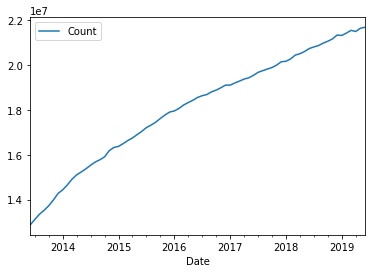

In [224]:
# Actual Data Plot
import matplotlib.pyplot as plt
df.plot()
plt.show()

Statistical analysis using ACF and PACF.

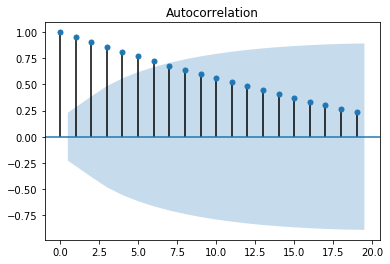

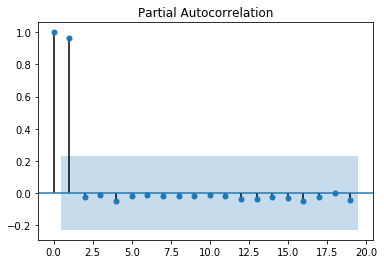

In [225]:
# ACF, PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df)
plot_pacf(df)
plt.show()

ACF clearly showing each lag correlation with actual data is gradually decreasing and PACF showing lag 1 only has strong correlation with actual data. It indicates data has strong trend and auto-regression with lag 1 is the best algorithm for this data set.

In [226]:
# Importing libraries
from sklearn.linear_model import LinearRegression
from numpy import sum as arraysum
from numpy import sqrt
import numpy as np

In [227]:
def autoregression(df, CI = 3.08):
    '''
        autoregression function with lag 1
        df - data frame 
        CI - confidence interval for boundary
    '''
    df['lag1'] = df['Count'].shift(1)
    df = df[1:]
    train = df.head(len(df.index) - 1)
    test = df.tail(1)
    X = train['lag1'].values.reshape(-1, 1)
    y = train['Count'].values
    # Fitting Simple Linear Regression to the Training set
    regressor = LinearRegression()
    regressor.fit(X, y)
    # Predicting the Training set results
    train_pred = regressor.predict(X)
    # Predicting the Test set results
    test_pred = regressor.predict(test['lag1'].values.reshape(-1, 1))
    df['forecast'] = train_pred.tolist() + test_pred.tolist()
    y = df['Count'].head(len(df.index) - 1).values
    yhat = df['forecast'].head(len(df.index) - 1).values
    # estimate stdev on errors
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)
    # calulate prediction interval
    interval = CI * stdev
    df['upper'] = [y_out + interval for y_out in df.forecast]
    df['lower'] = [y_out - interval for y_out in df.forecast]
    df['anomaly'] = np.where((df['Count'] >= df['lower']) & (df['Count'] <= df['upper'])
                     , 'False', 'True')
    df['residual'] = df['Count'] - df['forecast']
    return df.tail(1)

In [228]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Idea is to find results for latest 36 months. For every forecast consider last 36 data points. 

In [229]:
start = len(df.index)-35
end = len(df.index) + 1
for i in list(range(start, end)):
    if i == start:
        anomaly_df = autoregression(df.head(i).tail(37), 3.08)
    else:
        anomaly_df = anomaly_df.append(autoregression(df.head(i).tail(37), 3.08))

In [230]:
def plot_anomaly(plot_df, plot_forecast=True):
#     plot_df = plot_df.set_index('Date')
    plot_df = plot_df.tail(36)
    series = plot_df.iloc[:,0]
    ax = plot_df.iloc[:,0].plot(marker='o',markersize=10, label='observed')
    # if plot_intervals:
    plot_df['lower_1'] = plot_df['lower']
    plot_df['upper_1'] = plot_df['upper']
    plot_df['lower'][:-6] = np.nan
    plot_df['upper'][:-6] = np.nan
    plot_df['lower_1'][-5:] = np.nan
    plot_df['upper_1'][-5:] = np.nan
    ax.fill_between(plot_df.index, plot_df['lower'], plot_df['upper'], color='k', alpha=.2)
    ax.fill_between(plot_df.index, plot_df['lower_1'], plot_df['upper_1'], color='k', alpha=.08)
    # if plot_anomalies:
    anomalies = plot_df['lower']
    anomalies = pd.DataFrame(anomalies)
    anomalies.columns = [plot_df.columns[0]]
    anomalies.iloc[:,0] = np.nan
    anomalies = anomalies.iloc[:,0]
    lowerBond = plot_df['lower']
    upperBond = plot_df['upper']
    anomalies[series.values<lowerBond.values] = series.values[series.values<lowerBond.values]
    anomalies[series.values>upperBond.values] = series.values[series.values>upperBond.values]
    anomalies[0] = np.nan
    anomalies.plot(marker='o',markersize=10, label = "Anomalies", color = 'r')

    if plot_forecast:
        plot_df.forecast.plot(marker='o',markersize=10, label='Forecast', color = 'g')
        plt.title('MAPE: ' + str(round(mean_absolute_percentage_error(plot_df.iloc[:,0], plot_df['forecast']),2)))      
    ax.set_xlabel('Date')
    ax.set_ylabel('Counts')
    plt.legend()
    plt.show()


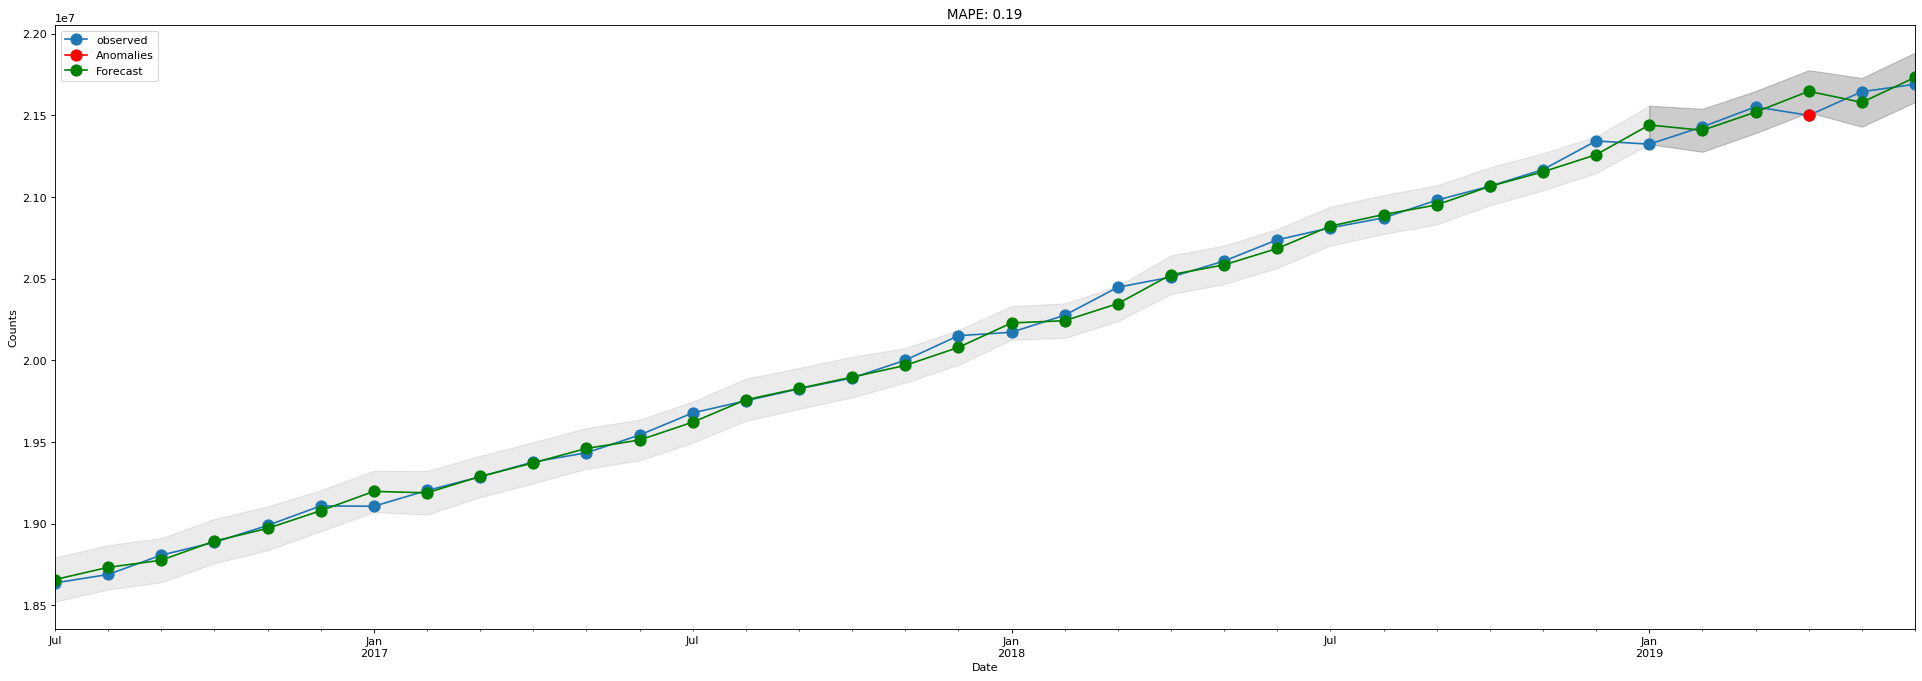

In [231]:
from pylab import *
fig=plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plot_anomaly(anomaly_df)

Above plot window contains 36 (3 years) data points with boundary but our main interest on latest 6 months anomalies. Here MAPE value is 0.19, it indicates this algorithm is best fit for the data. Coming to the boundary standard error multiplied with 3.08  it idicates confidence interval is 99%. 

# Seasonal Data

Import data

In [232]:
import pandas as pd
df = pd.read_csv('Data/Seasonal.csv', index_col='Date', parse_dates=['Date'] , dayfirst=True)
df.head()

,Count
Date,
2013-07-01,7375927
2013-08-01,7057069
2013-09-01,6495760
2013-10-01,7201793
2013-11-01,6888971


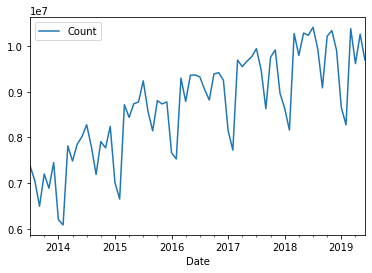

In [233]:
# Actual Data Plot
import matplotlib.pyplot as plt
df.plot()
plt.show()

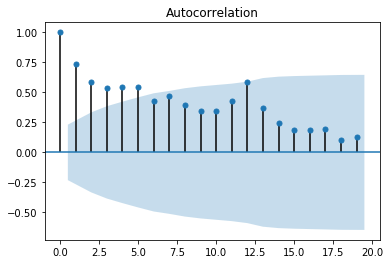

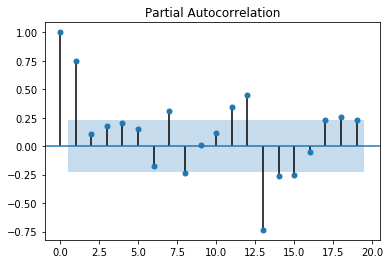

In [234]:
# ACF, PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df)
plot_pacf(df)
plt.show()

From ACF and PACF, due to zig zag patterns in lags we can consider data has seasonality. 

In [235]:
def seasonalAdjustmentMultiplicativeFactor(df,CI = 4.50):
    df['time'] = df.index + 1
    df['seasonal'] = df['Date'].map(lambda x: x.month)
    df['seasonal'] = df['seasonal'].astype('category')
    train = df.head(len(df.index) - 1)
    test = df.tail(1)
    X = train['time'].values.reshape(-1, 1)
    y = train['Count'].values
    # Fitting Simple Linear Regression to the Training set
    regressor = LinearRegression()
    regressor.fit(X, y)
    # Predicting the Training set results
    train_pred = regressor.predict(X)
    # Predicting the Test set results
    test_pred = regressor.predict(test['time'].values.reshape(-1, 1))
    df['regressin_pred'] = train_pred.tolist() + test_pred.tolist()
    #Seasonal adjustment as a Multiplicative Factor
    train['mae'] =train['Count'] / regressor.predict(X)
    mean_df = train.loc[:,['seasonal','mae']].groupby(['seasonal']).mean()
    mean_df.reset_index(level=0, inplace=True)
    mean_df = mean_df.rename(columns={'mae': 'seasonalMul'})
    df = pd.merge(df,
                 mean_df,
                 on='seasonal', 
                 how='left')
    pred = train_pred * df['seasonalMul'][:-1]
    pred = pred.append(test_pred * df['seasonalMul'][-1:])
    df['forecast'] = pred
    y = df['Count'].head(len(df.index) - 1).values
    yhat = df['forecast'].head(len(df.index) - 1).values
    # estimate stdev of yhat
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)
    # calulate prediction interval
    interval = CI * stdev
    df['upper'] = [y_out + interval for y_out in df.forecast]
    df['lower'] = [y_out - interval for y_out in df.forecast]
    df['anomaly'] = np.where((df['Count'] >= df['lower']) & (df['Count'] <= df['upper'])
                     , 'False', 'True')
    df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())
    df['MAE'] = train['mae'] + [0] 
    df['residual'] = df['Count'] - df['forecast']
    return df.tail(1)

In [236]:
df2 = df
df2 = df2.reset_index()
df2.head()

,Date,Count
0,2013-07-01,7375927
1,2013-08-01,7057069
2,2013-09-01,6495760
3,2013-10-01,7201793
4,2013-11-01,6888971


In [237]:
start = len(df2.index)-35
end = len(df2.index) + 1
for i in list(range(start, end)):
    if i == start:
        anomaly_df = seasonalAdjustmentMultiplicativeFactor(df2.head(i).tail(37), 3.08)
    else:
        anomaly_df = anomaly_df.append(seasonalAdjustmentMultiplicativeFactor(df2.head(i).tail(37), 3.08))

For every forecast consider last 36 data points. 

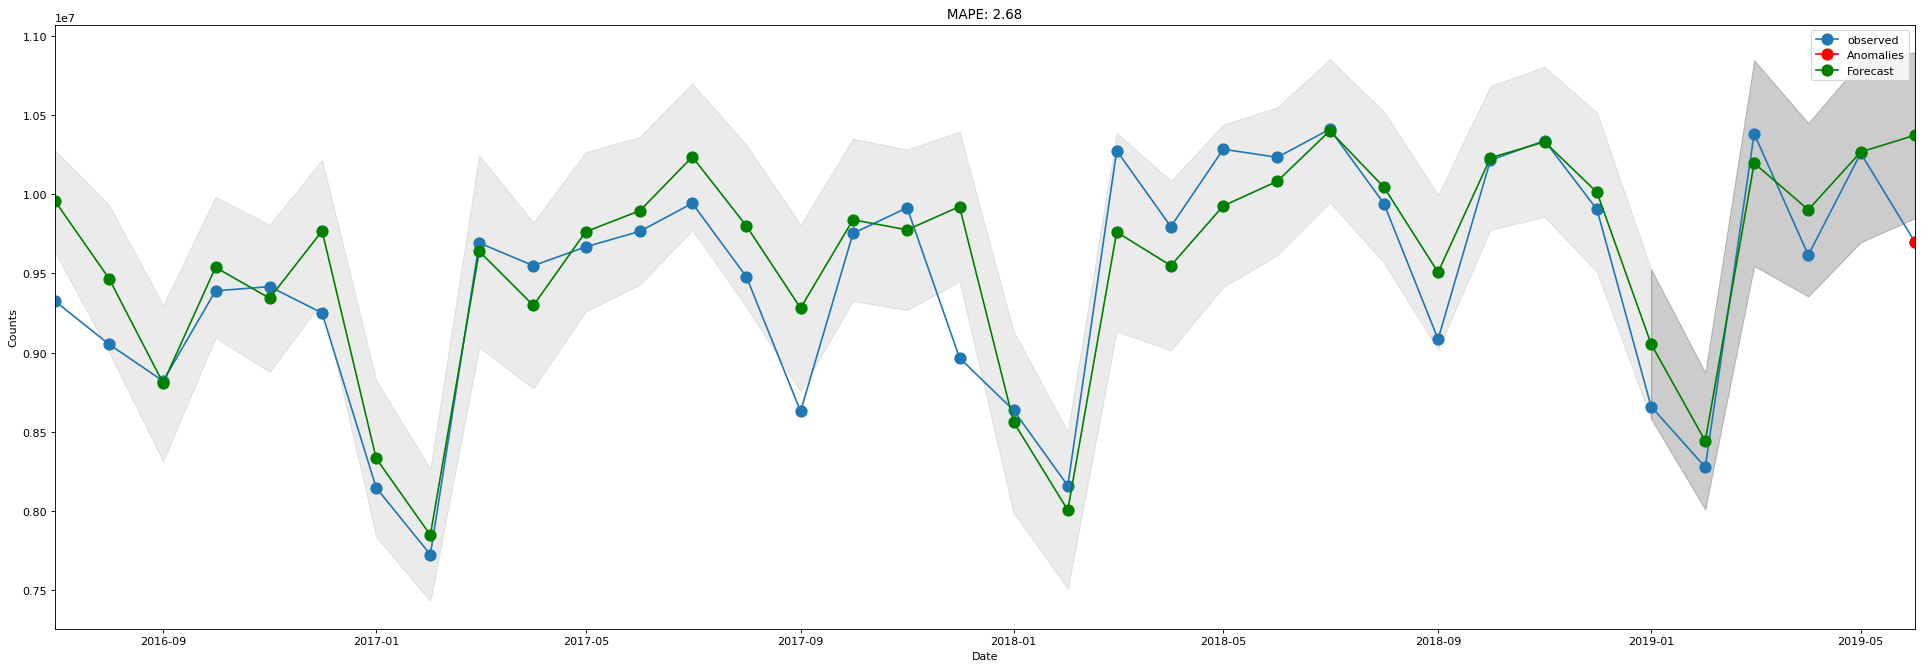

In [238]:
plot_df = anomaly_df.set_index('Date')
fig=plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plot_anomaly(plot_df)

Reason for using basic algorithms:
1. Easy explainability :
    At the end of every results explainability is more important in data science. By using Auto regression or Seasonality Adjustment by Multiplicative Factor algorithms anomalies explanation is much easier using last three years data. 
2. Model deployment free:
    Using these algorithms deployment of model is not necessary. In this design on fly automatically build model and produce best results. 
3. Performance:
    Compared to fancy time series algorithms basic algorithms execution time is faster.